In [3]:
from knnroadgraph.data.points import InsideAirbnbLoader
from knnroadgraph.data.base import OverpassRoadLoader
from knnroadgraph.algorithms.geograph import GeoGraph
from knnroadgraph.algorithms.knngraph import SkKnnGraph
from knnroadgraph.plotting.basic import plot_geograph
from knnroadgraph.plotting.roads import plot_segment_predictions, get_segment_predictions
from sklearn.metrics.pairwise import euclidean_distances
from scipy import stats
from random import random
import numpy as np

In [4]:
bbox = [4.322295,51.173265,4.476062,51.265779]
roadloader = OverpassRoadLoader(bbox=bbox, transform="to_belgian")
roads = roadloader.load()

In [5]:
roads

In [6]:
points, y_vals = InsideAirbnbLoader(file_name="listings-antwerp.csv").load()

In [7]:
graph = GeoGraph(roads, points, y_vals)

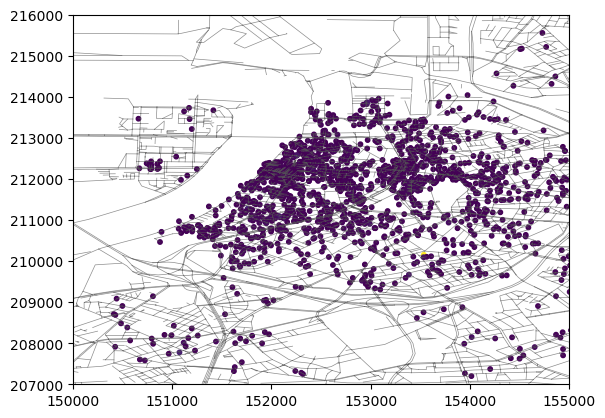

In [8]:
plot_geograph(graph, xlim=(150000,155000), ylim=(207000, 216000), y_vals=y_vals)

In [11]:
def split_indices(graph, train=.7, z_score=3, max_dist=500):
    indices = np.random.permutation(len(graph.y_vals))
    if z_score:
        indices = indices[np.where(stats.zscore(graph.y_vals[indices]) <= 3)[0]]
    if max_dist:
        Xs = graph.get_X(indices, False)
        E = euclidean_distances(Xs)
        E[E == 0] = np.max(E) + 1
        m = np.min(E, axis=0) > 500
        indices = indices[~m]
    train_idx, test_idx = indices[:int(len(indices)*train)], indices[int(len(indices)*train):]
    return train_idx, test_idx

In [12]:
model = SkKnnGraph(
    distance_matrix_file=str(random()), # name to save dist matrix to
    n_neighbors=20,
    distance_scaler="none",
    distance_minmax=False,
    weight_method="distance",
    temperature=1,
    power=1,
    decay=0,
    jitter=0,
)

train_idx, test_idx = split_indices(graph)
model.train(graph, train_idx)

In [ ]:
node_preds = {node: model.predict_node(graph, node) for node in graph.graph.nodes}
segment, z_list = get_segment_predictions(graph.graph, node_preds)

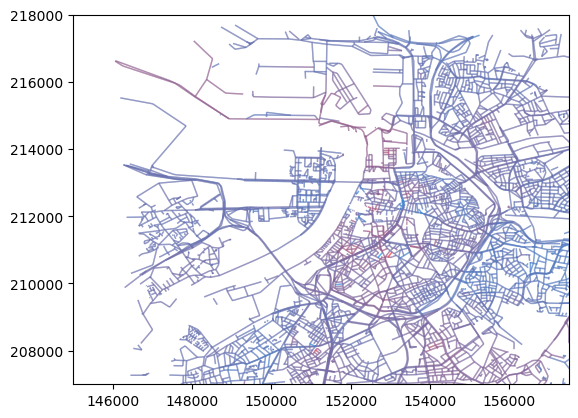

In [33]:
plot_segment_predictions(
    segment,
    np.array(z_list), 
    xlim=(145000,157500), ylim=(207000, 218000)
)